In [1]:
%matplotlib inline

import torch

from torch.autograd import Variable
from torch.nn.init import xavier_normal

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [2]:
BATCH_SIZE = 150

transform = transforms.ToTensor()

# Load and transform data
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [3]:
class StackedAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size=300, coding_size=150):
        super(StackedAutoEncoder, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, coding_size)
        self.hidden3 = nn.Linear(coding_size, hidden_size)
        self.output = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        hidden1_output = F.elu(self.hidden1(x))
        hidden2_output = F.elu(self.hidden2(hidden1_output))
        hidden3_output = F.elu(self.hidden3(hidden2_output))
        output = self.output(hidden3_output)
        return output, hidden2_output

In [4]:
sae = StackedAutoEncoder(input_size=28*28)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(sae.parameters(), weight_decay=1e-5)

In [6]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [7]:
N_EPOCHS = 5 
total_loss = 0
print_every = 5000 // BATCH_SIZE
plot_every = 500 // BATCH_SIZE
all_losses = []
iter = 1

start = time.time()

for e in range(N_EPOCHS):
    for i_batch, batch in enumerate(trainloader):
        image = batch[0]
        label = batch[1]
        image = Variable(image.view(-1, 1, 28*28))
        
        sae.zero_grad()
        output, coding = sae(image)
        loss = criterion(output, image)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        
        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / (len(trainloader) * N_EPOCHS) * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        iter = iter + 1

0m 0s (33 1%) 0.0396
0m 0s (66 3%) 0.0274
0m 1s (99 4%) 0.0198
0m 1s (132 6%) 0.0157
0m 1s (165 8%) 0.0136
0m 2s (198 9%) 0.0115
0m 2s (231 11%) 0.0113
0m 2s (264 13%) 0.0102
0m 3s (297 14%) 0.0096
0m 3s (330 16%) 0.0087
0m 3s (363 18%) 0.0087
0m 4s (396 19%) 0.0081
0m 4s (429 21%) 0.0079
0m 4s (462 23%) 0.0080
0m 5s (495 24%) 0.0078
0m 5s (528 26%) 0.0073
0m 5s (561 28%) 0.0073
0m 6s (594 29%) 0.0072
0m 6s (627 31%) 0.0067
0m 7s (660 33%) 0.0066
0m 7s (693 34%) 0.0065
0m 7s (726 36%) 0.0067
0m 8s (759 37%) 0.0067
0m 8s (792 39%) 0.0064
0m 8s (825 41%) 0.0062
0m 9s (858 42%) 0.0063
0m 9s (891 44%) 0.0062
0m 9s (924 46%) 0.0061
0m 10s (957 47%) 0.0062
0m 10s (990 49%) 0.0060
0m 10s (1023 51%) 0.0060
0m 11s (1056 52%) 0.0064
0m 11s (1089 54%) 0.0059
0m 11s (1122 56%) 0.0059
0m 12s (1155 57%) 0.0059
0m 12s (1188 59%) 0.0056
0m 12s (1221 61%) 0.0055
0m 13s (1254 62%) 0.0059
0m 13s (1287 64%) 0.0054
0m 14s (1320 66%) 0.0057
0m 14s (1353 67%) 0.0059
0m 15s (1386 69%) 0.0057
0m 15s (1419 70%)

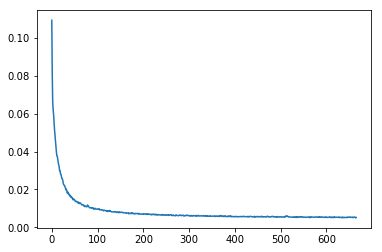

In [8]:
plt.plot(all_losses)